In [37]:
import yaml
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [38]:
excel = Path("../Data/Asplund_2008.xlsx")

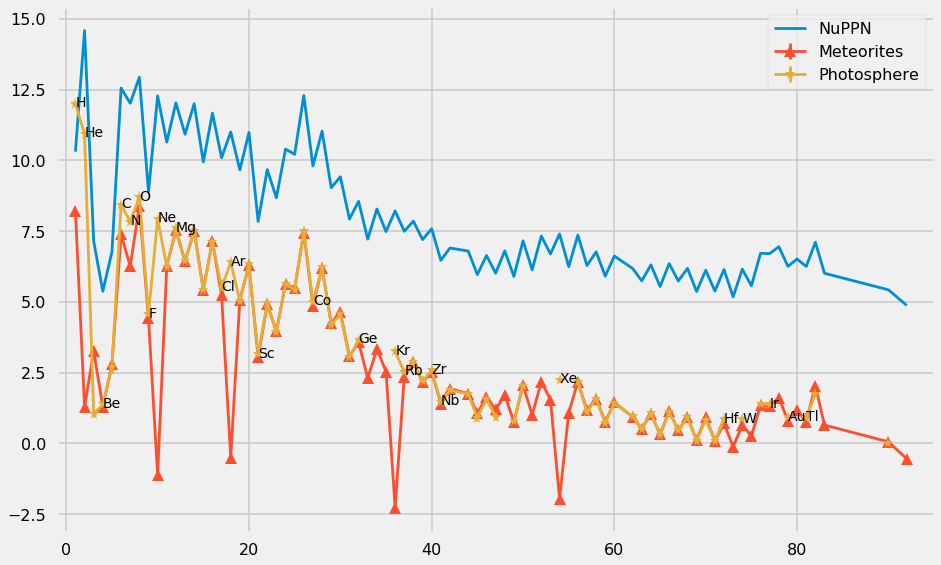

In [39]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(1,1,1)

df_ppn = pd.read_excel(excel, sheet_name = "nuppn")
abu = df_ppn.groupby(['Z', "Element"])["Abundance"].sum().reset_index()

dex = []

for z, element, abundance in zip(abu.Z, abu.Element, abu.Abundance):
    dex.append(np.log10(abundance/(abu.Abundance.iloc[13]))+12)

df = pd.read_excel(excel)
ax.plot(abu.Z, dex, label="NuPPN")

ax.errorbar(x=df.Z, y=df.Meteorites, yerr=df["Meteorites uncertainty"], fmt='^-', label="Meteorites")
ax.errorbar(x=df.Z, y=df.Photosphere, yerr=df["Photosphere uncertanty"], fmt='*-', label="Photosphere")

for element, z, photo, meteo in zip(df.Element, df.Z, df.Photosphere, df.Meteorites):
    if photo - meteo > 0.05:
        ax.text(z, photo-0.1, element)
        
ax.set_xlim(-1,95)        
ax.legend(loc=1)

In [40]:
path = Path("../Data/Asplund.yml")
assert not path.is_file()

abu = {e:p for e, p in zip(df.Element, df.Photosphere) if not math.isnan(p)} 
error = {e:p for e, p in zip(df.Element, df["Photosphere uncertanty"]) if not math.isnan(p)} 

dic = {"Star": "Sun", "Abundance": {"Loge": abu, "Loge_error": error}}

AssertionError: 

In [41]:
with path.open('w') as file:
    yaml.dump(dic, file)

In [42]:
with Path("../Data/Asplund.yml").open() as file:
    asplund = yaml.load(file, Loader=yaml.FullLoader)

print(asplund)

{'Abundance': {'Loge': {'Ag': 0.94, 'Al': 6.45, 'Ar': 6.4, 'Au': 0.92, 'B': 2.7, 'Ba': 2.18, 'Be': 1.38, 'C': 8.43, 'Ca': 6.34, 'Ce': 1.58, 'Cl': 5.5, 'Co': 4.99, 'Cr': 5.64, 'Cu': 4.19, 'Dy': 1.1, 'Er': 0.92, 'Eu': 0.52, 'F': 4.56, 'Fe': 7.5, 'Ga': 3.04, 'Gd': 1.07, 'Ge': 3.65, 'H': 12.0, 'He': 10.93, 'Hf': 0.85, 'Ho': 0.48, 'In': 0.8, 'Ir': 1.38, 'K': 5.03, 'Kr': 3.25, 'La': 1.1, 'Li': 1.05, 'Lu': 0.1, 'Mg': 7.6, 'Mn': 5.43, 'Mo': 1.88, 'N': 7.83, 'Na': 6.24, 'Nb': 1.46, 'Nd': 1.42, 'Ne': 7.93, 'Ni': 6.22, 'O': 8.69, 'Os': 1.4, 'P': 5.41, 'Pb': 1.75, 'Pd': 1.57, 'Pr': 0.72, 'Rb': 2.52, 'Rh': 0.91, 'Ru': 1.75, 'S': 7.12, 'Sc': 3.15, 'Si': 7.51, 'Sm': 0.96, 'Sn': 2.04, 'Sr': 2.87, 'Tb': 0.3, 'Th': 0.02, 'Ti': 4.95, 'Tl': 0.9, 'Tm': 0.1, 'V': 3.93, 'W': 0.85, 'Xe': 2.24, 'Y': 2.21, 'Yb': 0.84, 'Zn': 4.56, 'Zr': 2.58}, 'Loge_error': {'Ag': 0.1, 'Al': 0.03, 'Ar': 0.13, 'Au': 0.1, 'B': 0.2, 'Ba': 0.09, 'Be': 0.09, 'C': 0.05, 'Ca': 0.04, 'Ce': 0.04, 'Cl': 0.3, 'Co': 0.07, 'Cr': 0.04, 'Cu': 